# T4 - Diffusion Models: Outpainting & Textual Refinement

Este notebook implementa duas das tarefas propostas no trabalho T4:
1.  **Outpainting:** Expansão de imagens além das bordas originais.
2.  **Textual Refinement:** Edição de partes da imagem guiada por texto.

Também inclui o cálculo das métricas **SSIM** e **LPIPS** para avaliação quantitativa.

## 1. Instalação e Configuração
Instalação das bibliotecas necessárias da Hugging Face e métricas.

In [9]:
!pip install -q diffusers transformers accelerate torch opencv-python pillow torchmetrics lpips

In [3]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageOps
import requests
from io import BytesIO
import numpy as np

# Setup Device (CUDA for Nvidia, MPS for Mac M1/M2, or CPU)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Inpainting Pipeline (Efficient for both Outpainting and Refinement)
model_id = "sd-legacy/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None # Disable safety checker to save memory/avoid false positives
).to(device)

/home/flavex/.pyenv/versions/cv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:01,  3.55it/s]An error occurred while trying to fetch /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb

## 2. Funções Auxiliares
Função para baixar uma imagem de exemplo para testes.

In [6]:
# Download a sample image (Vermeer's Girl with a Pearl Earring is classic for outpainting tests)
url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/1665_Girl_with_a_Pearl_Earring.jpg"
# Use wget to download the image silently
!wget -q -O original.png {url}

# Load the image using PIL after downloading
init_image = Image.open("original.png").convert("RGB").resize((512, 512))
print("Sample image downloaded and loaded.")

/home/flavex/.pyenv/versions/cv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (178746750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Sample image downloaded and loaded.


## 3. Implementação: Outpainting
Esta função cria um "canvas" maior, centraliza a imagem original e instrui o modelo a preencher o espaço vazio (branco na máscara).

100%|██████████| 50/50 [05:30<00:00,  6.61s/it]


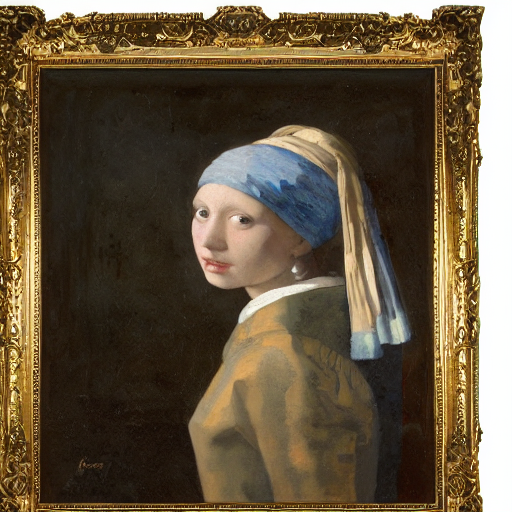

In [7]:
def perform_outpainting(image, prompt, expand_factor=1.5, steps=50):
    """
    Expands the image canvas and fills the new area using Stable Diffusion.
    """
    width, height = image.size
    new_width = int(width * expand_factor)
    new_height = int(height * expand_factor)
    
    # 1. Create a new canvas with gray background
    new_image = Image.new("RGB", (new_width, new_height), (128, 128, 128))
    
    # 2. Paste the original image in the center
    x_offset = (new_width - width) // 2
    y_offset = (new_height - height) // 2
    new_image.paste(image, (x_offset, y_offset))
    
    # 3. Create Mask: White area is filled, Black area is preserved
    mask = Image.new("L", (new_width, new_height), 255) # Start full white (fill everything)
    mask_black = Image.new("L", (width, height), 0) # Black box for original image
    mask.paste(mask_black, (x_offset, y_offset))
    
    # 4. Inference
    result = pipe(
        prompt=prompt,
        image=new_image,
        mask_image=mask,
        num_inference_steps=steps,
        strength=1.0 # Strength 1.0 ensures the masked area is fully regenerated
    ).images[0]
    
    return result, mask

# --- TEST OUTPAINTING ---
prompt_out = "classic oil painting, museum background, detailed frame, baroque style"
outpainted_img, out_mask = perform_outpainting(init_image, prompt_out)

outpainted_img.save("result_outpainting.png")
display(outpainted_img)

## 4. Implementação: Textual Refinement
Usa o mesmo pipeline, mas focamos em alterar uma área existente. O parâmetro `strength` é crucial aqui: valores altos mudam completamente o objeto; valores baixos mantêm a estrutura original.

100%|██████████| 42/42 [04:22<00:00,  6.24s/it]


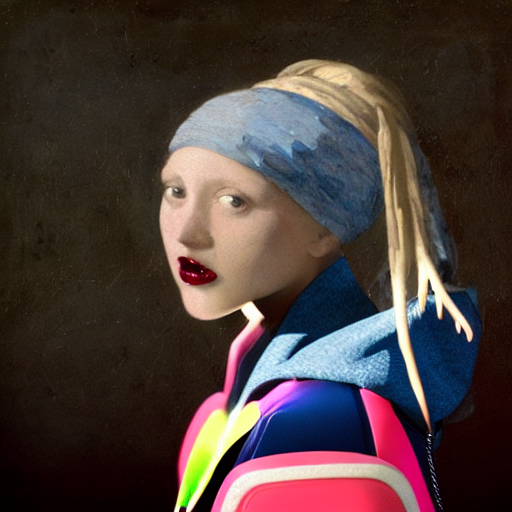

In [8]:
def perform_refinement(image, mask_image, prompt, strength=0.8, steps=50):
    """
    Refines or replaces a specific area of the image defined by the mask.
    """
    # Resize image to 512x512 to save memory if needed
    image = image.resize((512, 512))
    mask_image = mask_image.resize((512, 512))

    result = pipe(
        prompt=prompt,
        image=image,
        mask_image=mask_image,
        num_inference_steps=steps,
        strength=strength # Higher strength = more creative freedom away from original pixels
    ).images[0]
    
    return result

# --- TEST REFINEMENT ---
# 1. Create a dummy mask (e.g., masking the bottom half to change clothes)
w, h = init_image.size
refinement_mask = Image.new("L", (w, h), 0) # Black
refinement_mask.paste(255, (0, h//2, w, h)) # White on bottom half

# 2. Run Refinement
prompt_refine = "a girl wearing a futuristic cyberpunk jacket, neon lights, high detail"
refined_img = perform_refinement(init_image, refinement_mask, prompt_refine, strength=0.85)

refined_img.save("result_refinement.png")
display(refined_img)

## 5. Avaliação (Métricas Perceptuais)
Cálculo de SSIM (estrutural) e LPIPS (perceptual, baseada em VGG).

In [10]:
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import torchvision.transforms.functional as TF

def calculate_metrics(img_path_a, img_path_b):
    # Load images
    img_a = Image.open(img_path_a).convert("RGB").resize((512, 512))
    img_b = Image.open(img_path_b).convert("RGB").resize((512, 512))
    
    # Convert to Tensor and normalize to [0, 1]
    tensor_a = TF.to_tensor(img_a).unsqueeze(0).to(device) # Shape: (1, 3, H, W)
    tensor_b = TF.to_tensor(img_b).unsqueeze(0).to(device)

    # 1. SSIM (Higher is better, max 1.0)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    score_ssim = ssim(tensor_a, tensor_b)
    
    # 2. LPIPS (Lower is better, 0.0 means identical)
    # net_type='vgg' is standard for perceptual comparison
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)
    score_lpips = lpips(tensor_a * 2 - 1, tensor_b * 2 - 1) # LPIPS expects [-1, 1] range usually

    return score_ssim.item(), score_lpips.item()

# Calculate metrics between Original and Refined
s_val, l_val = calculate_metrics("original.png", "result_refinement.png")

print(f"--- Metrics (Original vs Refined) ---")
print(f"SSIM: {s_val:.4f} (Structural Similarity)")
print(f"LPIPS: {l_val:.4f} (Perceptual Distance)")
print("Note: For Outpainting, crop the center of the result before comparing if you want to measure fidelity of the preserved area.")

/home/flavex/.pyenv/versions/cv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (178746750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/flavex/.pyenv/versions/cv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/flavex/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:11<00:00, 46.7MB/s] 


--- Metrics (Original vs Refined) ---
SSIM: 0.5866 (Structural Similarity)
LPIPS: 0.4565 (Perceptual Distance)
Note: For Outpainting, crop the center of the result before comparing if you want to measure fidelity of the preserved area.
